# Performance for Classification

In [7]:
import mglearn
import sklearn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mlxtend.classifier import Adaline
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions

from scipy.special import expit

from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import load_breast_cancer, load_iris, make_classification
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.linear_model import Perceptron, LogisticRegression

In [8]:
def plot_digit(image_data):
    image = image_data.reshape((28, 28))
    plt.imshow(image, cmap='binary')
    plt.axis('off')

## Data loading

In [9]:
heart = pd.read_csv('data/heart.csv')
labels = heart['output'].values
heart.drop(['output'], axis=1, inplace=True)

In [11]:
heart_ct = ColumnTransformer(
    transformers=[
        ('1', MinMaxScaler(), ['age', 'caa', 'slp', 'thall']),
        ('2', OneHotEncoder(drop='first', categories='auto'), ['cp', 'restecg']), # we remove the first column generated by OHE, we don't need it
        ('3', StandardScaler(), ['trtbps', 'oldpeak', 'chol', 'fbs', 'thalachh'])
    ],
    verbose_feature_names_out=False, # reduce the name of the features given by OHE when it creates new columns
    remainder='passthrough' # the column not specified above are not the subject of transformation
)

X = heart_ct.fit_transform(heart) # this is wrong!!! We must actually apply it after the train test split

Once a model or a few models have been trained, how can we evaluate their performance? 
We introduce a few performance measures, assessing how good is our model in solving the task.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, shuffle=True, stratify=labels)

In [15]:
sum(y_train == 1) / len(y_train), sum(y_test == 1) / len(y_test)

(0.5454545454545454, 0.5409836065573771)

Stratification worked.

In [16]:
knn_clf = KNeighborsClassifier(n_neighbors=3) # build classifier
knn_clf.fit(X_train, y_train) # train classifier
y_train_predicted = knn_clf.predict(X_train) # run predictions on train labels
y_test_predicted = knn_clf.predict(X_test)

In [19]:
y_test_predicted[:10], y_train_predicted[:10]

(array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0]), array([1, 0, 1, 0, 0, 0, 1, 0, 1, 1]))

Clearly, they are not the same.

## Confusion matrix

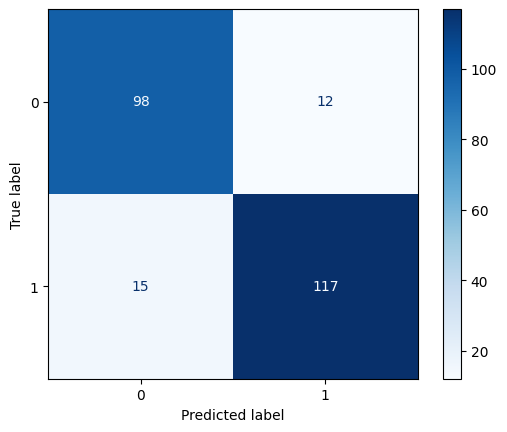

array([[ 98,  12],
       [ 15, 117]])

In [17]:
conf_matrix = confusion_matrix(y_train, y_train_predicted)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predicted, cmap=plt.cm.Blues)
plt.show()
conf_matrix

Recall score is very high (supposed to be), so is Precision, and they are very close. F1 is very high, obviously. But this is only for the training set. And the model is based on KNN, which is a subject for overfitting.
Now we shall do the real test, we'll use the test set. We are evaluating if the model can properly generalize.

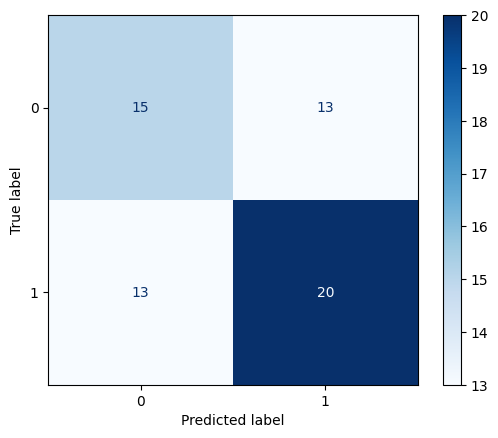

array([[15, 13],
       [13, 20]])

In [21]:
conf_matrix = confusion_matrix(y_test, y_test_predicted)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predicted, cmap=plt.cm.Blues)
plt.show()
conf_matrix

## Accuracy

In [22]:
accuracy_score(y_train, y_train_predicted), accuracy_score(y_test, y_test_predicted)

(0.8884297520661157, 0.5737704918032787)

On the test the algorithm is not as good as on the train.

## Recall

In [23]:
recall_score(y_train, y_train_predicted), recall_score(y_test, y_test_predicted)

(0.8863636363636364, 0.6060606060606061)

## Precision

In [24]:
precision_score(y_train, y_train_predicted), precision_score(y_test, y_test_predicted)

(0.9069767441860465, 0.6060606060606061)

## F1-score

Recap of the situation.

In [25]:
f1_score(y_train, y_train_predicted), f1_score(y_test, y_test_predicted)

(0.896551724137931, 0.6060606060606061)

In the case of KNN we can analyze the impact of the k on the performance of the classifier. Here, we focus on recall as a function of hyperparameter k.